In [32]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag
import bs4
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from lxml import html
import lxml
import collections.abc as clct

## Searching for croissant baking temperatures
- Searches for 'croissant bake temperature' or 'temperature cuisson croissant' were conducted on Google country-specific search sites for the US, UK, and France. The first 100 links were obtained for each country. These links were subsequently scraped to determine if they were a croissant baking recipe, and if so, for their initial baking temperature.
- Baking temperatures were found by looking for sentences that contained the words 'preheat', 'bake', or 'oven' followed by a 3 digit number followed by a temperature indicator. 
- Croissant baking often employs a two-stage approach with a high starting temp followed by a lower finishing temp. The script pulled the first temperature mention, so this is the starting temp.
- For the US graphic, websites were excluded if the first temperature mention was in celsius.
- For the UK and French graphics, websites were excluded if the first temperature mention was in fahrenheit.


## Tools and techniques used in this project
- **Tools**
> - Python, Jupyter Lab, Beautiful Soup, Pandas, Numpy
- **Visualization**
> - Matplotlib
- **Techniques**
> - Web-scraping


In [228]:
def find_value_of_nested_dict_or_list(a, our_key):
    if not isinstance(a, clct.Iterable):
        return False
    if isinstance(a, str):
        return False
    if isinstance(a, list):
        for item in a:
            result = find_value_of_nested_dict_or_list(item, our_key)
            if result:
                return result
    if isinstance(a, dict):
        for key in a:
            if key == our_key:
                return a[our_key]
            else:
                result = find_value_of_nested_dict_or_list(a[key], our_key)
                if result:
                    return result
    return False

In [229]:
# not in use
def string_from_soup(content):
#     print(content)
    if isinstance(content, str):
        return content
    elif isinstance(content, bs4.element.Tag):
        return content.text
    elif isinstance(content, list):
        for item in content:
            result = string_from_soup(item)
            if result:
                return result
    else:
        return 'Not list or string'

In [202]:
url = 'https://www.marthastewart.com/312981/croissants' # 3 1st level is list. target dict is in 2nd position of list
url = 'https://sallysbakingaddiction.com/homemade-croissants/' # 1. type(data) dict. 
# url = 'https://www.kingarthurbaking.com/recipes/bakers-croissants-recipe' # 1target in dict?
# url = 'https://www.finecooking.com/recipe/classic-croissants' # target in dict
# url = 'https://www.jocooks.com/recipes/homemade-croissants/' # target in dict

# url = 'https://www.epicurious.com/recipes/food/views/butter-croissants-103989' #No application/ld+json. Yes to schema.org recipe, but old format
# url = 'https://www.weekendbakery.com/posts/classic-french-croissant-recipe/' # No application/ld+json
# url = 'https://gourmetier.com/french-croissants/'   # class="entry-content". dict, but target not in dict
# url = 'https://topwithcinnamon.com/how-to-make-croissants/'  # dict, but target not in dict
# url = 'https://www.noellecarterfood.com/blog/2019/9/20/better-baking-temperature-croissants-recipe' # dict, but target not in dict

# url = 'https://bakingamoment.com/easy-homemade-croissant-recipe/'
# url = 'https://www.joyofbaking.com/breads/HomemadeCroissants.html'
# url = 'https://www.foodandwine.com/recipes/croissants'
# url = 'https://bakerpedia.com/processes/croissant/'
# url = 'https://www.halfbakedharvest.com/homemade-croissants-step-step-photos/'
# url = 'https://www.foodnetwork.com/recipes/food-network-kitchen/homemade-croissants-5277802'
# url = 'https://www.tastingtable.com/cook/recipes/croissants-recipe-french-pastry'
# url = 'https://www.bbcgoodfood.com/recipes/croissants' #recipeInstructions appears twice. Value is erased on the second pass?
# url = 'https://www.masterclass.com/articles/make-the-perfect-croissant-with-chef-dominique-ansel' # not working--probable redirect
# url = 'https://buttermilkpantry.wordpress.com/2019/07/06/how-to-make-croissants/' # not working--"Connection aborted"

# url = 'https://www.artisanbryan.com/post/how-to-make-croissants-recipe'
# url = 'https://www.paulhollywood.com/post/croissants'

try:       
    r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
    if r.status_code == 406:
        r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html')
        json_data = soup.findAll(type="application/ld+json")

#         print(soup.prettify())
#         print(len(json_data))
        if len(json_data) > 0:                # For sites that follow schema.org for 'Recipe'
                    for i in range(len(json_data)):
                        data = json.loads(json_data[i].string)
#                         self.ingredients = find_value_of_nested_dict_or_list(data,'recipeIngredient')
                        print(url)
                        check = find_value_of_nested_dict_or_list(data,'recipeInstructions')
                        if check:
                            instr = []
                            if isinstance(check[0], dict):
                                for dct_ in check:
                                    if 'text' in dct_.keys():
                                        instr = dct_['text']
                                        print(instr)
                            else:
                                instr = ''.join(check)
                                print(instr)
#                         self.recipe_name = find_value_of_nested_dict_or_list(data,'name')
#                         self.cook_time = find_value_of_nested_dict_or_list(data,'cookTime')
#                         self.url = url

        if len(json_data) == 0 or find_value_of_nested_dict_or_list(data,'recipeInstructions') == False:     # For sites that do not follow schema.org for 'Recipe'
                    result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 
                                                                   'hrecipe', 'post-entry', 'post-content', 'post-content__body','recept', 'recipe-content']})
                    soup_string = ''
                    for r in result:
                        soup_string += str(r.text)
                    print(url)
                    print(len(soup_string))
#                     self.instructions = soup_string
#                     self.url = url


                        
#         result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 'post-entry', 'recept', 'recipe-content']})
#         soup_string = ''
#         for r in result:
#             soup_string += str(r.text)
        
#         print(soup_string)

except Exception as e:
    print('Exception', e)

https://sallysbakingaddiction.com/homemade-croissants/
Watch the video above and use the step-by-step photos before you begin. Read the recipe before beginning. Make room in the refrigerator for a baking sheet. In step 6 and again in step 13, you will need room for 2 baking sheets.
Cut the butter in four 1-Tablespoon pieces and place in the bowl of an electric stand mixer fitted with the dough hook attachment (or you can use a handheld mixer or no mixer, but a stand mixer is ideal). Add the flour, sugar, salt, and yeast. Turn the mixer on low-medium speed to gently combine the ingredients for 1 minute. With the mixer running, slowly pour in the milk. Once all of the milk is added, turn the mixer up to medium-high speed and beat the dough for at least 5 full minutes. (If you don’t have a mixer, knead by hand for 5 minutes.) The dough will be soft. It will (mostly) pull away from the sides of the bowl and if you poke it with your finger, it will bounce back. If after 5 minutes the dough 

In [251]:
class ClassifyWebpage:
    '''Classify webpage'''
    def __init__(self, search_pattern_1, search_pattern_2):
        self.url = None
        self.page_genus = 'pastry'
        self.page_family = ''
        self.page_species = ''
#         self.pastry_genus_predict = PastryRecipeWebpage()
#         self.pastry_family_predict = PastryRecipeWebpage()
#         self.pastry_species_predict = PastryRecipeWebpage()
        self.language = "Not found in page source"
        self.recipe_name = ''
        self.cook_time = ''
        self.ingredients = ''
        self.instructions = ''
    
    def parse_webpage(self, url):
        try:
            r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
            if r.status_code == 406:
                r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
            if r.status_code == 200:
#                 print(f'Pass {url}')
                root = lxml.html.fromstring(r.text)
                language_construct = root.xpath("//html/@lang") # this xpath is reliable(in long-term), since this is a standard construct.
                if language_construct:
                    language = language_construct[0].split('-')[0]
                    self.language = language    
        
                soup = BeautifulSoup(r.content, 'html')
                json_data = soup.findAll(type="application/ld+json")

                # For sites that follow schema.org for 'Recipe'
                if len(json_data) > 0:                
                    for i in range(len(json_data)):
                        data = json.loads(json_data[i].string)
                        check = find_value_of_nested_dict_or_list(data,'recipeInstructions')
                        if check:
                            instr = []
                            if isinstance(check[0], dict):
                                for dct_ in check:
                                    if 'text' in dct_.keys():
                                        self.instructions = dct_['text']
#                                         print(instr)
                            else:
                                instr = ''.join(check)
                                self.instructions = instr
                            self.ingredients = find_value_of_nested_dict_or_list(data,'recipeIngredient')
                            self.recipe_name = find_value_of_nested_dict_or_list(data,'name')
                            self.cook_time = find_value_of_nested_dict_or_list(data,'cookTime')
                            self.url = url

                # For sites that do not follow schema.org for 'Recipe'
                if len(json_data) == 0 or find_value_of_nested_dict_or_list(data,'recipeInstructions') == False:     
                    result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 
                                                                   'hrecipe', 'post-entry', 'post-content', 
                                                                   'post-content__body','recept', 'recipe-content']})
                    soup_string = ''
                    for r in result:
                        soup_string += str(r.text)
                    self.instructions = soup_string
                    self.url = url
                
                return {'instructions' : self.instructions,
                        'url' : self.url
                       }
                              
            else:
                print(' ')
#                 print(f'Fail {r.status_code}, {url}')
        except Exception as e:
            pass
            print('Exception', e)
            


In [231]:
class PastryRecipeWebpage:
    '''A recipe for hand-made croissants'''
    def __init__(self, instructions=None, initial_temp=None, second_temp=None):
        '''Initialize the recipe's attributes'''
        self.instructions = instructions
        self.initial_temp = initial_temp
        if initial_temp and initial_temp > 300:
            self.initial_temp_range = 'US'
        else:
            self.initial_temp_range = 'Europe'
        self.second_temp = second_temp
    

## Step one
### Get links for the target search term

In [364]:
#  The easiest way to change the search is to type a search in google then COPY and PASTE the address. If you try to assign variable to the function call it won't recognize {bundle}.
#  Convert to an f string, find start=0 in the string and change it to start={bundle}.

# us_google_url=f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969"
# fr_google_url=f"https://www.google.fr/search?q=temp%C3%A9rature+cuisson+croissant&ei=0PEzX4C2PMXk-gTv_ImwCA&start={bundle}&sa=N&ved=2ahUKEwiA3szk5ZXrAhVFsp4KHW9-AoYQ8NMDegQIDRBC&biw=1848&bih=942"
# uk_google_url=f"https://www.google.co.uk/search?q=croissant+temperature&ei=OPQzX8T0KMj4-gSnn5moBw&start={bundle}&sa=N&ved=2ahUKEwjE8JaK6JXrAhVIvJ4KHadPBnUQ8NMDegQIDhA_&biw=1848&bih=942"
us_puff_pastry = f'https://www.google.com/search?q=how+to+make+puff+pastry+dough&client=ubuntu&hs=GNM&channel=fs&sxsrf=ALeKk011tOIIja512_JwZ8zfTmHSiLc9HA:1598459179879&ei=K41GX96hNcP7-gTrwZCYAg&start=10&sa=N&ved=2ahUKEwie4-q8pLnrAhXDvZ4KHesgBCMQ8NMDegQIDhBA&biw=1637&bih=942'

target_links = 280
page_bundles = list(range(140,target_links,10))
links=[]
for bundle in page_bundles:
    links_list = get_links_from_google_search(f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969")
    for link in links_list:
        links.append(link)

NameError: name 'bundle' is not defined

### Write results to file from Google search function

In [10]:
# Uncomment country to write results

# uk_croissant_links = pd.DataFrame(links)
# uk_croissant_links.to_csv('data/uk-croissant-links.txt')

# us_croissant_links = pd.DataFrame(links)
# us_croissant_links.to_csv('data/us-croissant-links.txt')

# fr_croissant_links = pd.DataFrame(links)
# fr_croissant_links.to_csv('data/fr-croissant-links.txt')

## Step two
### Read in links file and initiate web search

In [238]:
# url_list = pd.read_csv('data/fr-croissant-links.txt',header=None)
# url_list = pd.read_csv('data/uk-croissant-links.txt',header=None)
url_list = pd.read_csv('data/us-croissant-links.txt',header=None)
# url_list = pd.read_csv('data/us-croissant-links-2.txt', header=None)

In [239]:
print(url_list)

       0                                                  1
0      5  https://sallysbakingaddiction.com/homemade-cro...
1      6  https://www.kingarthurbaking.com/recipes/baker...
2      7  https://www.epicurious.com/recipes/food/views/...
3      8  https://www.weekendbakery.com/posts/classic-fr...
4      9  https://www.finecooking.com/recipe/classic-cro...
..   ...                                                ...
133  139  https://physicstoday.scitation.org/doi/pdf/10....
134  140  http://thebreadlab.wsu.edu/wp-content/uploads/...
135  141      http://www.freepatentsonline.com/4986992.html
136  142  https://butterandbliss.net/homemade-flaky-croi...
137  143  https://forktospoon.com/air-fryer-5-minute-cro...

[138 rows x 2 columns]


In [252]:
# search_string_1 = r'([A-Z][^.]*(?:four|cuisson|cuir|chauff)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #French regex
# search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:ºC| ºC|°C| °C|C| C)[^.]*(?:[.]|[\s]))' #UK regex
search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #US regex
search_string_2 = r'(\d{3})'

good_url, bad_url, instr, init_temp, init_temp_range = [], [], [], [], []
hits = 0
misses = 0

recipe_dict = []

scraper = ClassifyWebpage(search_string_1, search_string_2)

for i in range(40):
    recipe_dict.append(scraper.parse_webpage(url_list[1][i]))
    time.sleep(1)
print(len(recipe_dict))

 
Exception ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Exception Invalid control character at: line 7 column 357 (char 560)
 
 
40


In [253]:
recipe_dict

[{'instructions': 'Croissants taste best the same day they’re baked. Cover any leftover croissants and store at room temperature for a few days or in the refrigerator for up to 1 week. You can also freeze for up to 3 months, then thaw on the counter or overnight in the refrigerator. Warm up to your liking.',
  'url': 'https://sallysbakingaddiction.com/homemade-croissants/'},
 {'instructions': 'For the dough: Put the eggs and water in a large mixing bowl. Add 1 tablespoon of the sugar, 3 cups (362g) of the flour, and the yeast. Mix until well blended; set aside to let the sponge work., For the butter: Cut the butter into 1˝ chunks and combine with the salt and flour at low speed in a stand mixer just until smooth, with no lumps. Be careful not to beat too much; you don’t want to incorporate any air., Spread the butter on a piece of plastic wrap and shape into an 8˝ square. Wrap and refrigerate for 30 minutes., Finish the dough: Add the melted butter to the sponge. Whisk together the rem

In [256]:
for recipe in recipe_dict:
    print(len(recipe['instructions']))

288
3943
3434
15080
7341
286
5542
28072
298
7682
80
11318
3118
5334
355
232
2372
0


TypeError: 'NoneType' object is not subscriptable

In [240]:
print(len(recipe_dict))
for page in recipe_dict:
    if page.url:
        if page.instructions:
            if len(page.instructions)>0:
                good_url.append(page.url)
                instr.append(page.instructions)
                hits += 1
                       
        else:
            print(page.url)
            print("NO DATA")
            bad_url.append(page.url)
            misses += 1
print(f': Hits {hits}  Misses {misses}')

df = pd.DataFrame([good_url, instr]).T
# df = pd.DataFrame([good_url, instr, init_temp]).T

 
Exception ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Exception Invalid control character at: line 7 column 357 (char 560)
 
 
Exception Invalid control character at: line 52 column 131 (char 9447)
54
https://www.bbcgoodfood.com/recipes/croissants
NO DATA
https://www.foodiewithfamily.com/how-to-make-croissants/
NO DATA
https://www.lemaraisbakery.com/shop/one-dozen-frozen-ready-to-bake-french-croissants-4a6t8
NO DATA
https://www.williams-sonoma.com/products/croissant/
NO DATA
https://cooking.stackexchange.com/questions/105045/croissant-baking-temperature
NO DATA
https://www.hungryonion.org/t/please-help-me-bake-the-perfect-croissant/5549
NO DATA
https://lesaffreyeast.com/formula/croissants-frozen/
NO DATA
https://www.gourmetdirect.co.nz/cooking-tip/croissant-cooking-instructions/
NO DATA
https://persephonebakery.com/pages/baking-instructions-croissants
NO DATA
https://veenaazmanov.com/homemade-croissants-recipe/
NO DATA
https://www.yout

In [222]:
print(len(recipe_dict))

54


### Write search results to file

In [212]:
# Uncomment country to write results

us_df_croissant2 = pd.DataFrame(df)
us_df_croissant2.to_csv('data/us_croissant2.csv')

# uk_df = pd.DataFrame(df)
# uk_df.to_csv('data/uk_results.csv')

# fr_df = pd.DataFrame(df)
# fr_df.to_csv('data/fr_results.csv')

In [221]:
us_df_croissant2

,0,1
0,https://sallysbakingaddiction.com/homemade-cro...,Croissants taste best the same day they’re bak...
1,https://www.kingarthurbaking.com/recipes/baker...,For the dough: Put the eggs and water in a lar...
2,https://www.epicurious.com/recipes/food/views/...,YieldMakes 24 pastries\nActive Time2 hr\nTotal...
3,https://www.weekendbakery.com/posts/classic-fr...,It’s all about the layers…\nKlik hier voor Ned...
4,https://www.finecooking.com/recipe/classic-cro...,Combine all of the dough ingredients in the bo...
5,https://www.jocooks.com/recipes/homemade-crois...,Bake croissants: Preheat your oven to 400 F de...
6,https://topwithcinnamon.com/how-to-make-croiss...,\n\nCroissants are just one of those things wh...
7,https://gourmetier.com/french-croissants/,The preparation of the croissants consists of ...
8,https://www.marthastewart.com/312981/croissants,"Brush with egg: Preheat oven to 400 degrees, w..."
9,https://www.noellecarterfood.com/blog/2019/9/2...,“Chilled.” “Room temperature.” “Melted.” These...


## Results and visualizations
- Of the 100 links obtained from the Google search by country, 35-40 usable temperatures were obtained for the US distribution and for the French distribution.
- Only 10 usable temperatures were obtained for the UK distribution. This is likely due to many recipes of US origin appearing in the google.uk search and being filtered out due to the restriction that temps needed to be expressed primarily in celsius.
- Mean temperatures are similar for all three countries.
- The distributions are different for the countries with the US having a narrower distribution of initial baking temperature and the French distribution being wider.

In [132]:
data_us = pd.read_csv('data/us_results.csv',header=None)
data_uk = pd.read_csv('data/uk_results.csv',header=None)
data_fr = pd.read_csv('data/fr_results.csv',header=None)

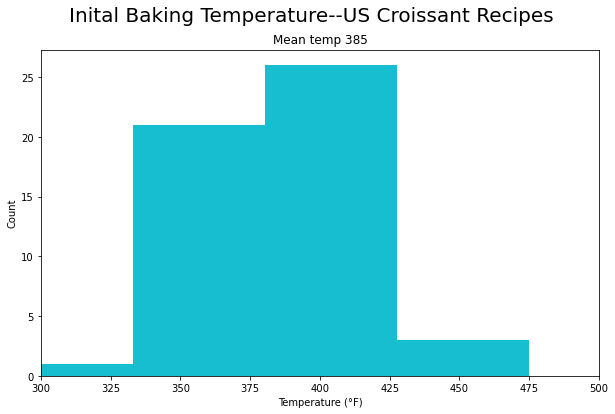

In [139]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(data_us.iloc[:,3], color='tab:cyan')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--US Croissant Recipes', size =20)
ax.set_title(f'Mean temp {data_us.iloc[:,3].mean():.0f}')
plt.savefig('img/us-croissant-baketemp-distribution.png')


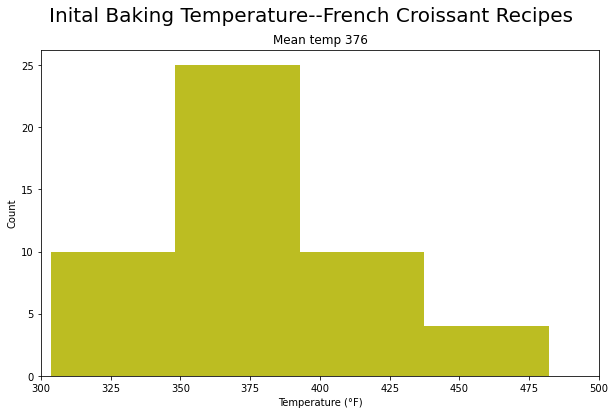

In [140]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_fr.iloc[:,3]*9/5+32), color='tab:olive')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--French Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_fr.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/fr-croissant-baketemp-distribution.png')
# (data_uk.iloc[:,2]*9/5+32).hist()
# (data_fr.iloc[:,2]*9/5+32).hist()


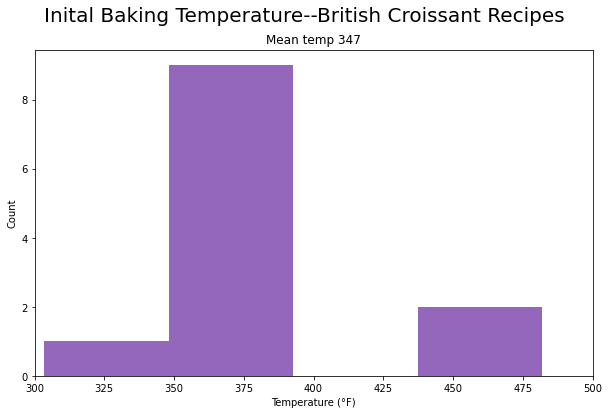

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_uk.iloc[:,3]*9/5+32), color='tab:purple')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--British Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_uk.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/uk-croissant-baketemp-distribution.png')


## Future Research
- Seek to obtain more usable temperatures by grabbing more links from Google and/or by refining the sifting of the websites to obtain a better yield.
- Consider how best to compare the distributions.
- Explore other parameters of croissant preparation and baking.
- Explore the comments for the various websites to determine if people in the respective countries interact differently with recipe authors.